# Team Payroll Efficiency Analysis (2000–2016)

This notebook analyzes how efficiently MLB teams convert payroll into on-field
performance using Wins Above Replacement (WAR) as an intermediary metric.

The analysis focuses on:
- The relationship between payroll, WAR, and wins
- Variation in efficiency across teams and seasons
- Evidence that WAR mediates the relationship between spending and success

All data ingestion and feature engineering were completed in Notebook 01.


## Load dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("../visuals", exist_ok=True)


df = pd.read_csv("../data/processed/team_wins_payroll_war_efficiency_2000_2016.csv")

print(df.shape)
df.head()

(510, 12)


,yearID,teamID,name,W,payroll,Batting_WAR,Pitching_WAR,Total_WAR,Dollars_per_Win,Dollars_per_WAR,WAR_per_Million,Wins_per_100M
0,2000,ANA,Anaheim Angels,82,51464167,30.250,8.410000,38.660000,6.276118e+05,1.331199e+06,0.751202,159.334164
1,2000,ARI,Arizona Diamondbacks,85,81027833,13.965,20.973333,34.938333,9.532686e+05,2.319167e+06,0.431189,104.902225
2,2000,ATL,Atlanta Braves,95,84537836,24.530,21.163333,45.693333,8.898720e+05,1.850113e+06,0.540507,112.375718
3,2000,BAL,Baltimore Orioles,74,81447435,17.065,8.560000,25.625000,1.100641e+06,3.178436e+06,0.314620,90.856145
4,2000,BOS,Boston Red Sox,85,77940333,15.940,24.290000,40.230000,9.169451e+05,1.937368e+06,0.516164,109.057784


In [24]:
df.isna().sum().sort_values(ascending=False).head(10)
df[["W", "payroll", "Total_WAR", "Batting_WAR", "Pitching_WAR"]].describe()

,W,payroll,Total_WAR,Batting_WAR,Pitching_WAR
count,510.000000,5.100000e+02,510.000000,510.000000,510.000000
mean,80.964706,8.650195e+07,33.439137,19.329698,14.109439
std,11.365111,3.992242e+07,10.850965,7.451069,6.009201
min,43.000000,1.467150e+07,1.088333,-0.510000,-2.316667
25%,72.000000,5.907392e+07,25.208333,14.506250,9.614488
50%,82.000000,8.041048e+07,34.031667,19.175000,14.395000
75%,90.000000,1.040865e+08,41.587927,24.148144,18.505000
max,116.000000,2.319789e+08,69.028333,47.425000,33.516667


## Big Picture Relationships

## Payroll and Wins

We begin by examining the relationship between team payroll and win totals to assess
whether spending alone is a reliable predictor of success.


<function matplotlib.pyplot.show(close=None, block=None)>

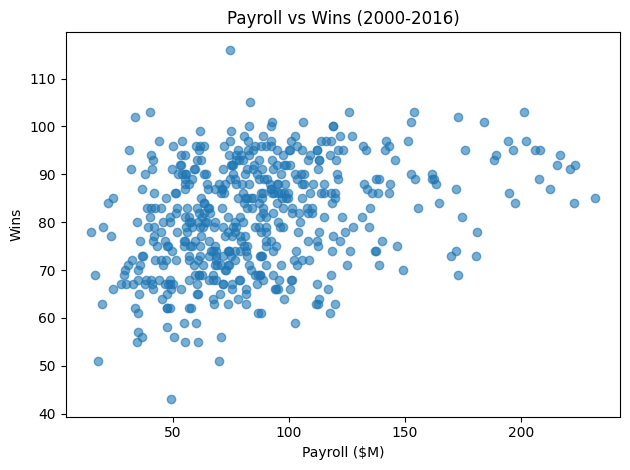

In [56]:
plt.figure()
plt.scatter(df["payroll"]/1e6, df["W"], alpha=0.6)
plt.xlabel("Payroll ($M)")
plt.ylabel("Wins")
plt.title("Payroll vs Wins (2000-2016)")

plt.tight_layout()
plt.savefig("../visuals/payroll_vs_wins.png", dpi=300)
plt.show

While payroll shows a positive relationship with wins, there is substantial
variation among teams with similar spending levels.


In [26]:
df[["W", "payroll", "Total_WAR"]].corr()

,W,payroll,Total_WAR
W,1.000000,0.342266,0.921338
payroll,0.342266,1.000000,0.334778
Total_WAR,0.921338,0.334778,1.000000


## WAR and Wins

Next, we evaluate the relationship between WAR and team wins to understand how
on-field value translates into performance.


<function matplotlib.pyplot.show(close=None, block=None)>

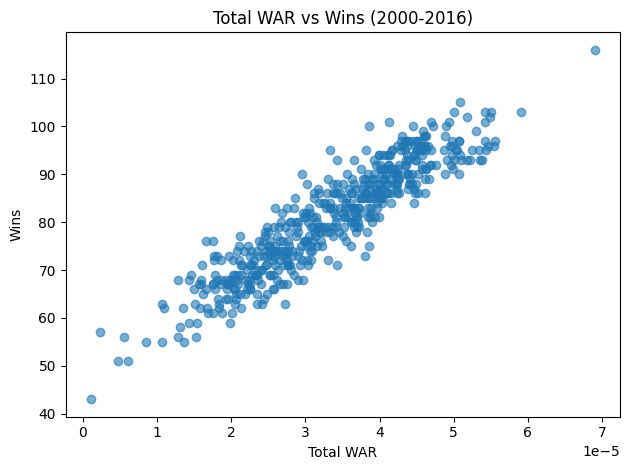

In [57]:
plt.figure()
plt.scatter(df["Total_WAR"]/1e6, df["W"], alpha=0.6)
plt.xlabel("Total WAR")
plt.ylabel("Wins")
plt.title("Total WAR vs Wins (2000-2016)")
plt.tight_layout()
plt.savefig("../visuals/War_vs_Wins_bubble.png", dpi=300)
plt.show

WAR exhibits a strong linear relationship with wins, suggesting it is a more
direct measure of team performance than payroll alone.


## Payroll and WAR

This section explores how effectively teams convert payroll into on-field value.


<function matplotlib.pyplot.show(close=None, block=None)>

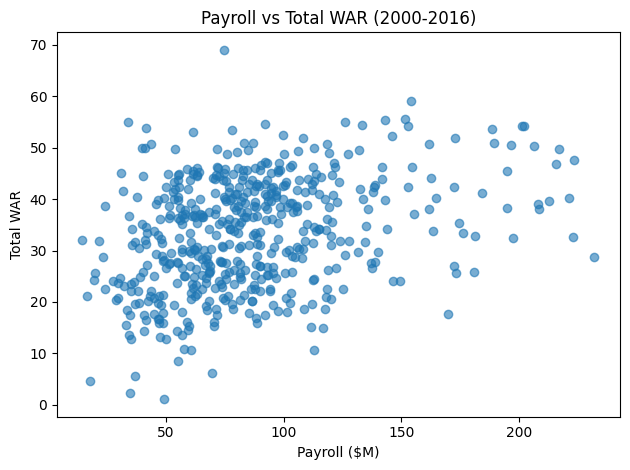

In [58]:
plt.figure()
plt.scatter(df["payroll"]/1e6, df["Total_WAR"], alpha=0.6)
plt.xlabel("Payroll ($M)")
plt.ylabel("Total WAR")
plt.title("Payroll vs Total WAR (2000-2016)")
plt.tight_layout()
plt.savefig("../visuals/payroll_vs_war_bubble.png", dpi=300)
plt.show

Teams with similar payrolls often generate very different WAR totals, indicating
significant differences in roster construction efficiency.


## Efficiency Metrics

To evaluate how effectively teams convert financial resources into on-field value,
we introduce several efficiency metrics. These metrics normalize performance by payroll,
allowing for comparisons across teams with vastly different spending levels.


In [ ]:
df = df.copy()
df["Dollars_per_Win"] = df["payroll"] / df["W"]
df["Dollars_per_WAR"] = df["payroll"] / df["Total_WAR"]
df["WAR_per_Million"] = df["Total_WAR"] / (df["payroll"]/1000000)



These efficiency metrics form the foundation of the remaining analysis, shifting the
focus from absolute spending to value generated per dollar.


## Distribution of Payroll Efficiency

We first examine the distribution of efficiency across all team-seasons to understand
the overall spread of cost-effectiveness in the league.


<function matplotlib.pyplot.show(close=None, block=None)>

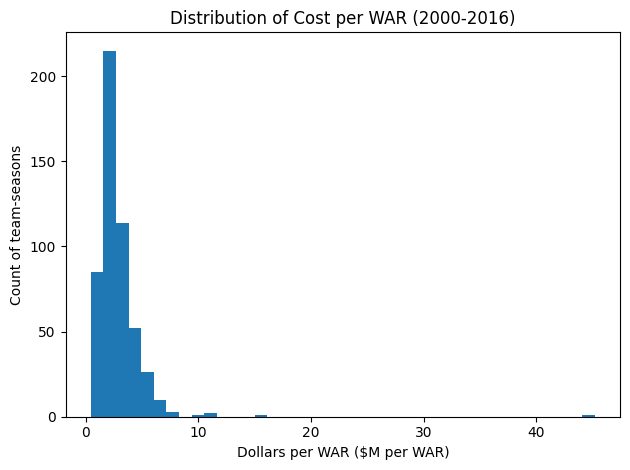

In [59]:
clean = df[df["Total_WAR"] > 0].copy()

plt.figure()
plt.hist(clean["Dollars_per_WAR"]/1e6, bins = 40)
plt.xlabel("Dollars per WAR ($M per WAR)")
plt.ylabel("Count of team-seasons")
plt.title("Distribution of Cost per WAR (2000-2016)")
plt.tight_layout()
plt.savefig("../visuals/cost_per_war_bar.png", dpi=300)
plt.show

The wide distribution highlights substantial variation in how teams allocate payroll,
with some organizations consistently generating significantly more value per dollar
than others.


## League-Wide Efficiency Trends Over Time

Examining efficiency trends over time provides context for how the cost of on-field value
has evolved across the league.


<function matplotlib.pyplot.show(close=None, block=None)>

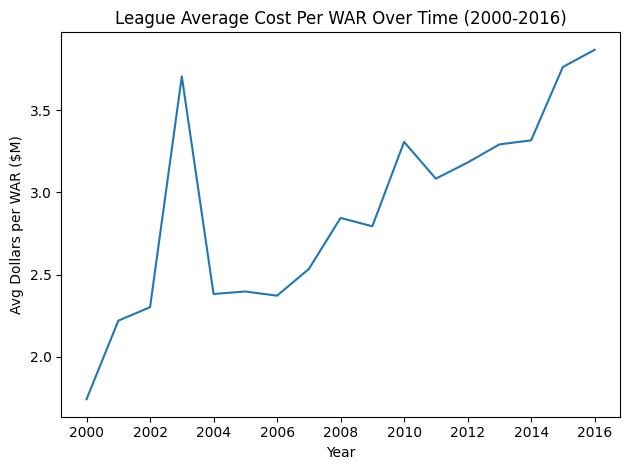

In [60]:
yearly = clean.groupby("yearID", as_index=False).agg(
    avg_dollars_per_war=("Dollars_per_WAR", "mean"),
    median_dollars_per_war=("Dollars_per_WAR", "median"),
    avg_payroll=("payroll", "mean"),
    avg_war=("Total_WAR", "mean"),
    avg_wins=("W", "mean")
)

plt.figure()
plt.plot(yearly["yearID"], yearly["avg_dollars_per_war"]/1e6)
plt.xlabel("Year")
plt.ylabel("Avg Dollars per WAR ($M)")
plt.title("League Average Cost Per WAR Over Time (2000-2016)")
plt.tight_layout()
plt.savefig("../visuals/avg_cost_per_war_line.png", dpi=300)
plt.show

The upward trend in cost per WAR reflects increasing player salaries over time, while
persistent variation around the league average suggests ongoing differences in team
strategy and execution.


## Team-Level Payroll Efficiency

To identify organizations that consistently outperform or underperform their payroll,
we aggregate efficiency metrics at the team level across multiple seasons.


In [32]:
team_summary = clean.groupby(["teamID"], as_index=False).agg(
    seasons=("yearID", "count"),
    avg_wins=("W", "mean"),
    avg_payroll=("payroll", "mean"),
    avg_war=("Total_WAR", "mean"),
    avg_cost_per_war=("Dollars_per_WAR", "mean"),
    median_cost_per_war=("Dollars_per_WAR", "median"),
)

team_summary=team_summary[team_summary["seasons"] >= 10].copy() # stability filter
team_summary.sort_values("median_cost_per_war").head(10)

,teamID,seasons,avg_wins,avg_payroll,avg_war,avg_cost_per_war,median_cost_per_war
11,FLO,12,80.250000,3.895117e+07,30.677670,1.278109e+06,1.234043e+06
22,OAK,17,85.882353,5.870295e+07,38.629942,1.698472e+06,1.418048e+06
29,TBA,17,75.764706,4.844585e+07,31.913883,1.703114e+06,1.423456e+06
18,MIN,17,80.235294,6.924926e+07,32.385957,2.713499e+06,1.773742e+06
8,CLE,17,81.470588,6.817136e+07,35.650339,2.091679e+06,1.916171e+06
25,SDN,17,76.529412,6.143429e+07,27.729597,2.430784e+06,2.066415e+06
31,TOR,17,81.352941,8.029162e+07,36.808295,2.212721e+06,2.086845e+06
24,PIT,17,73.352941,5.451046e+07,23.587985,3.145192e+06,2.094217e+06
2,ATL,17,86.823529,8.875199e+07,38.245105,2.460214e+06,2.152424e+06
1,ARI,17,78.705882,7.401161e+07,30.343725,3.028712e+06,2.319167e+06


Teams appearing near the top of the efficiency rankings demonstrate sustained ability
to generate on-field value relative to payroll, indicating organizational advantages
in roster construction and player development.


## WAR as a Mediating Variable

To better understand how payroll translates into wins, WAR is introduced as a third
dimension using bubble size. This visualization highlights differences in how effectively
teams convert spending into on-field value.



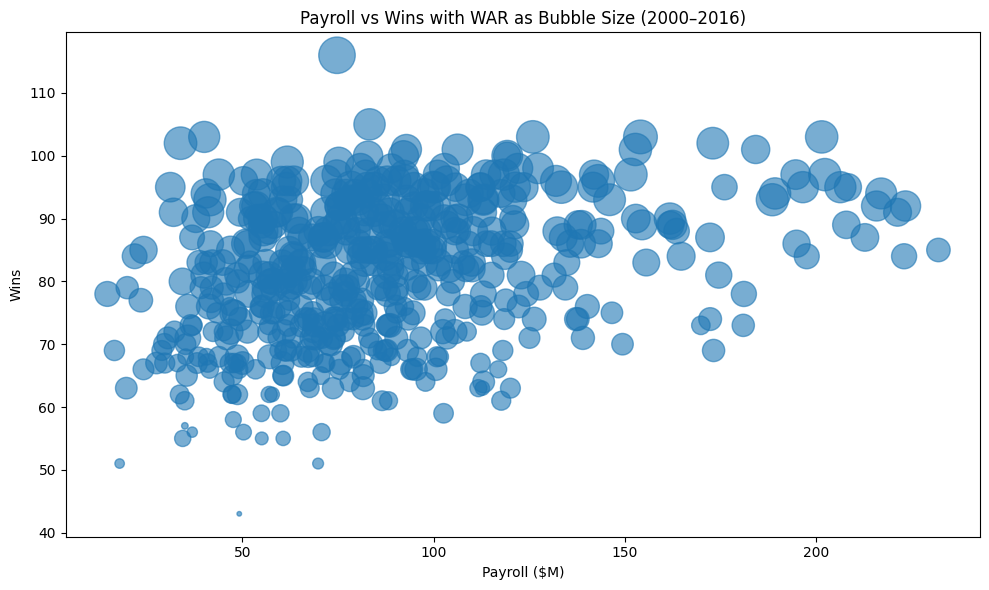

In [61]:
plt.figure(figsize=(10,6))

plt.scatter(
    df["payroll"]/1e6,
    df["W"],
    s=df["Total_WAR"]*10, #Scale for visibility
    alpha = 0.6
)


plt.xlabel("Payroll ($M)")
plt.ylabel("Wins")
plt.title("Payroll vs Wins with WAR as Bubble Size (2000–2016)")
plt.tight_layout()
plt.savefig("../visuals/payroll_vs_wins_war_scatter.png", dpi=300)
plt.show()

This visualization highlights WAR as the key mediating variable between payroll and wins.
Teams with similar payrolls often produce vastly different win totals depending on how
effectively spending translates into on-field value. Large bubbles at lower payroll levels
suggest efficient roster construction, while smaller bubbles among high-payroll teams
indicate diminishing returns on spending.


## Best Value Teams

To identify organizations that consistently maximize on-field value relative to payroll,
we rank teams based on their median WAR generated per million dollars spent across seasons.
Using the median helps reduce the influence of extreme single-season outliers.


In [38]:
team_efficiency = (
    df.groupby("teamID", as_index=False)
    .agg(
        seasons=("yearID", "count"),
        avg_efficiency=("WAR_per_Million", "mean"),
        median_efficiency=("WAR_per_Million", "median")
    )
)

# Require a reasonable number of seasons for stability
team_efficiency = team_efficiency[team_efficiency["seasons"] >= 10]

team_efficiency.sort_values("median_efficiency", ascending=False).head(10)


,teamID,seasons,avg_efficiency,median_efficiency
11,FLO,12,0.940498,0.810347
22,OAK,17,0.739654,0.705195
29,TBA,17,0.706162,0.702515
18,MIN,17,0.612302,0.563780
8,CLE,17,0.571466,0.521874
25,SDN,17,0.500858,0.483930
31,TOR,17,0.502636,0.479192
24,PIT,17,0.445557,0.477506
2,ATL,17,0.429045,0.464592
1,ARI,17,0.423064,0.431189


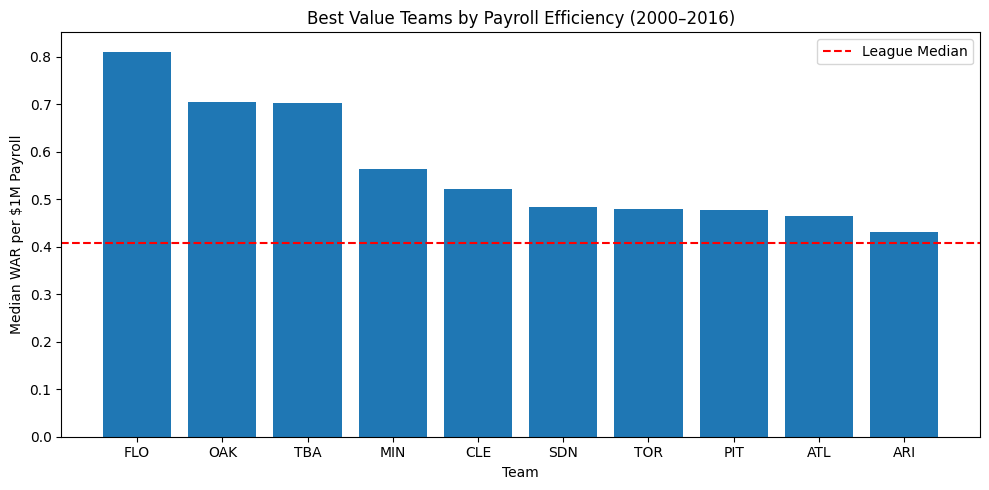

In [62]:
top_value = team_efficiency.sort_values(
    "median_efficiency", ascending=False
).head(10)

plt.figure(figsize=(10,5))
plt.bar(top_value["teamID"], top_value["median_efficiency"])
plt.axhline(
    df["WAR_per_Million"].median(),
    linestyle="--",
    color="red",
    label="League Median"
)
plt.legend()
plt.xlabel("Team")
plt.ylabel("Median WAR per $1M Payroll")
plt.title("Best Value Teams by Payroll Efficiency (2000–2016)")
plt.tight_layout()
plt.savefig("../visuals/best_value_bar.png", dpi=300)
plt.show()


Teams at the top of the value rankings consistently generate more WAR per dollar spent,
often operating with lower payrolls while remaining competitive. Notably, several
small- and mid-market teams appear prominently, suggesting that efficient roster
construction can partially offset financial disadvantages. 



High payroll efficiency does not necessarily imply sustained winning, but rather reflects
the ability to acquire on-field value at a lower cost.

To provide contrast, we next examine teams that consistently generate the least on-field
value relative to payroll.


In [40]:
team_efficiency.sort_values("median_efficiency").head(10)


,teamID,seasons,avg_efficiency,median_efficiency
20,NYA,17,0.255716,0.243918
21,NYN,17,0.323789,0.299893
27,SFN,17,0.403904,0.299918
15,LAN,17,0.330010,0.311851
14,LAA,12,0.327283,0.314609
10,DET,17,0.343264,0.321003
3,BAL,17,0.359633,0.332711
26,SEA,17,0.399059,0.334904
4,BOS,17,0.340785,0.351578
32,WAS,12,0.388928,0.355538


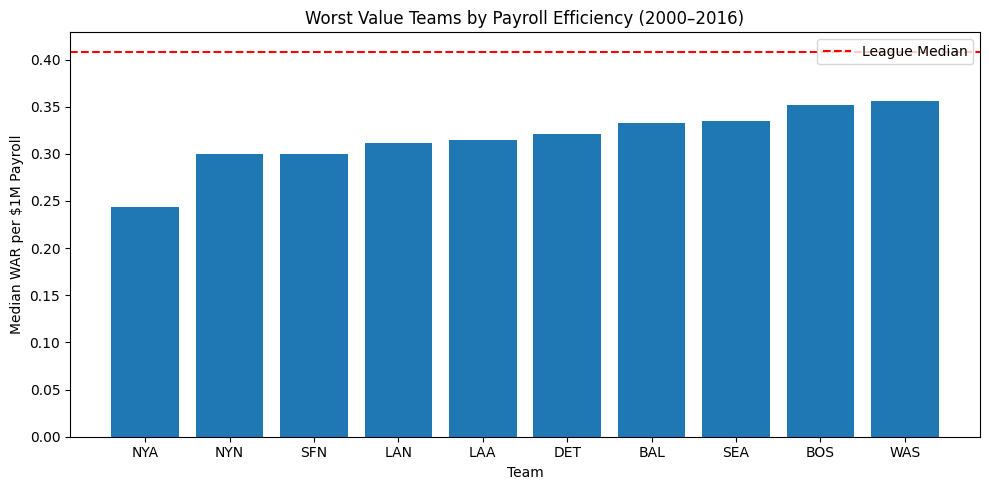

In [63]:
worst_value = team_efficiency.sort_values(
    "median_efficiency", ascending=True
).head(10)



plt.figure(figsize=(10,5))
plt.bar(worst_value["teamID"], worst_value["median_efficiency"])
plt.axhline(
    df["WAR_per_Million"].median(),
    linestyle="--",
    color="red",
    label="League Median"
)
plt.legend()
plt.xlabel("Team")
plt.ylabel("Median WAR per $1M Payroll")
plt.title("Worst Value Teams by Payroll Efficiency (2000–2016)")
plt.tight_layout()
plt.savefig("../visuals/worst_value_bar.png", dpi=300)
plt.show()


Teams appearing among the worst value rankings tend to operate with consistently high
payrolls that do not translate proportionally into on-field value. Several large-market
teams appear in this group, highlighting the diminishing returns associated with
aggressive spending absent efficient roster construction.



These results do not imply persistent organizational failure, but rather reflect periods
where payroll growth outpaced value generation.

## Summary

This notebook shows that payroll alone is an incomplete explanation for team success.
WAR provides the critical link between spending and wins, revealing large differences
in how efficiently teams convert financial resources into on-field value.

The next notebook formalizes these findings using statistical models to quantify the
relationship between payroll, WAR, and team wins.
